# Recommender System Modeling

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from network import Ranking
from data import RecoData, collate_fn
from train import train, test

pd.set_option('display.max_rows', 100)
random.seed(0)
torch.manual_seed(233)

## 1. 公开数据
数据来自天池的淘宝电商数据集，已做预处理。
处理后的数据包含以下字段：
1. user:  用户id
2. item:  物品id
3. category:  物品分类
4. behavior:  用户行为，包含浏览（pv），加购物车（cart），收藏（fav），购买（buy）
5. timestamp:  时间戳
6. item_list:  用户以往交互过的物品id列表
7. cate_list:  用户以往交互过的物品分类id列表
8. behavior_list:  用户以往交互过的行为列表

原链接：https://tianchi.aliyun.com/dataset/dataDetail?dataId=649

In [2]:
df = pd.read_csv("data/taobao_hot_small.csv")   # 进一步可以使用全量数据 data/taobao_hot.csv
df.head(10)

,user,item,category,behavior,timestamp,item_list,cate_list,behavior_list
0,0,4,0,pv,1511669729,"[0, 1, 2, 1, 3]","[0, 1, 2, 1, 0]","['pv', 'pv', 'cart', 'pv', 'cart']"
1,0,5,3,pv,1511669796,"[0, 1, 2, 1, 3, 4]","[0, 1, 2, 1, 0, 0]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv']"
2,0,6,0,pv,1511672939,"[0, 1, 2, 1, 3, 4, 5]","[0, 1, 2, 1, 0, 0, 3]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv']"
3,0,7,0,pv,1511672951,"[0, 1, 2, 1, 3, 4, 5, 6]","[0, 1, 2, 1, 0, 0, 3, 0]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."
4,0,8,4,pv,1511672973,"[0, 1, 2, 1, 3, 4, 5, 6, 7]","[0, 1, 2, 1, 0, 0, 3, 0, 0]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."
5,0,6,0,pv,1511672981,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8]","[0, 1, 2, 1, 0, 0, 3, 0, 0, 4]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."
6,0,8,4,pv,1511703434,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8, 6]","[0, 1, 2, 1, 0, 0, 3, 0, 0, 4, 0]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."
7,0,9,2,pv,1511703467,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8, 6, 8]","[0, 1, 2, 1, 0, 0, 3, 0, 0, 4, 0, 4]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."
8,0,10,5,pv,1511704082,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8, 6, 8, 9]","[0, 1, 2, 1, 0, 0, 3, 0, 0, 4, 0, 4, 2]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."
9,0,11,6,pv,1511704161,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8, 6, 8, 9, 10]","[0, 1, 2, 1, 0, 0, 3, 0, 0, 4, 0, 4, 2, 5]","['pv', 'pv', 'cart', 'pv', 'cart', 'pv', 'pv',..."


### 数据分布

以下直方图中，横轴为单用户对应的样本数，纵轴为浏览记录达到该值的用户数

<AxesSubplot:>

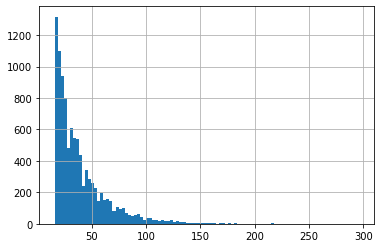

In [3]:
uh = df.groupby("user").count()
uh["item"].hist(bins=100)

用户平均浏览数量

In [4]:
df.groupby("user")["item"].count().mean()

39.1967

用户行为分布

In [5]:
df.groupby("behavior")["item"].count()

behavior
buy       5584
cart     20064
fav      11259
pv      355060
Name: item, dtype: int64

### 模型简介

#### 算法：
DIEN，本质为对用户对物品的历史交互行为序列进行建模，从而达到对目标物品更准确的预估。

#### 输入特征：
1. 用户侧特征: user_id
2. 目标物品特征: item_id, item_category
3. 用户历史序列: item_list, cate_list, behavior_list

#### 建模过程：

DIEN 模型示意图，原论文链接：https://arxiv.org/pdf/1809.03672.pdf
![dien](./data/dien.jpg)

实际模型结构除一些细微差别外，总体和上图一致。

1. Embedding层: user_embedding, target_item_embedding, user_behavior_sequence_embedding
2. 循环网络层: hidden_encoding = GRU ( user_behavior_sequence_embedding ) 
3. 注意力层: atten_encoding = Attention ( q = hidden_encoding, k = target_item, v = target_item )
4. 合并层: all_encoding = Concat(atten_encoding, target_item_embedding, user_embedding)
5. 全连接层: output = FC2 ( FC1 ( all_encoding ) )

loss_fn 使用了二分类交叉熵，并对预估所得的购买概率和实际是否购买计算 AUC 值。天池公布的 baseline auc = 0.622。

In [6]:
train_df = df[df["timestamp"] < 1512144000]   # 对应日期 2017-11-25 ~ 2017-12-02
eval_df = df[df["timestamp"] >= 1512144000]   # 对应日期 2017-12-03 ~ 2017-12-04

train_info = train(train_df, eval_df, epochs=3, batch_size=32)   # 可根据需要调整训练的 epoch 数量，以及 batch_size 的大小

start processing train data
start processing eval data
train start
[epoch  0 batch  500] train_loss: 0.1747, 	 eval_loss: 0.0782, 	 auc: 0.557859
[epoch  0 batch 1000] train_loss: 0.0918, 	 eval_loss: 0.0722, 	 auc: 0.553547
[epoch  0 batch 1500] train_loss: 0.0816, 	 eval_loss: 0.0709, 	 auc: 0.565621
[epoch  0 batch 2000] train_loss: 0.0772, 	 eval_loss: 0.0704, 	 auc: 0.581292
[epoch  0 batch 2500] train_loss: 0.0745, 	 eval_loss: 0.0703, 	 auc: 0.593562
[epoch  0 batch 3000] train_loss: 0.0763, 	 eval_loss: 0.0702, 	 auc: 0.615013
[epoch  0 batch 3500] train_loss: 0.0701, 	 eval_loss: 0.0697, 	 auc: 0.606536
[epoch  0 batch 4000] train_loss: 0.0756, 	 eval_loss: 0.0698, 	 auc: 0.607809
[epoch  0 batch 4500] train_loss: 0.0802, 	 eval_loss: 0.0695, 	 auc: 0.616478
[epoch  0 batch 5000] train_loss: 0.0654, 	 eval_loss: 0.0694, 	 auc: 0.616629
[epoch  0 batch 5500] train_loss: 0.0753, 	 eval_loss: 0.0690, 	 auc: 0.633582
[epoch  0 batch 6000] train_loss: 0.0694, 	 eval_loss: 0.0690, 	

### 结果图示

#### Loss 变化曲线

<AxesSubplot:xlabel='step'>

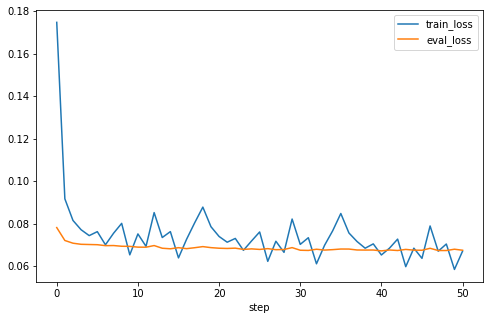

In [7]:
train_info.plot(x="step", y=["train_loss", "eval_loss"], figsize=(8, 5))

#### AUC 变化曲线

该结果在 small 训练集上，仅用 3 个 epoch 已经能达到 0.7 左右的 auc 值，远超于天池给的 0.622 的参考基线。

<AxesSubplot:xlabel='step'>

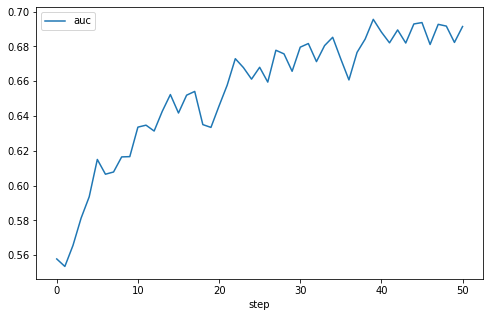

In [8]:
train_info.plot(x="step", y=["auc"], figsize=(8, 5))

#### 对测试集进行评估

In [9]:
test_result = test(eval_df)   # 这里测试也使用了验证集

/Users/lixuelin/code/DI-reco/train.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred"] = pred


下面对 pv, cart, fav, buy 4个行为做聚合，计算预估分的均值。
1. 模型对 buy 行为的预估分最高，符合预期。
2. cart 行为（加购物车）排在第二，也体现了添加购物车和购买商品之间存在着紧密的关联。

In [10]:
test_result.groupby("behavior")["pred"].mean()

behavior
buy     0.024515
cart    0.016054
fav     0.013647
pv      0.013193
Name: pred, dtype: float64

随机选取用户，可见对于用户真实购买的物品，模型给出的预估值高于大多数仅浏览的物品的预估值。

In [11]:
test_result[test_result["user"] == 9771][["user", "item", "behavior", "pred"]]

,user,item,behavior,pred
382715,9771,5187,pv,0.009694
382716,9771,7707,fav,0.002517
382717,9771,1300,pv,0.009317
382718,9771,5244,fav,0.006606
382719,9771,2581,fav,0.005638
382720,9771,3589,pv,0.022085
382721,9771,5606,fav,0.007961
382722,9771,535,pv,0.045520
382723,9771,3593,pv,0.007398
382724,9771,3604,pv,0.115556
